In [1]:
# load data
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("/users/zouyang/fer2013.csv")

In [2]:
# random select 1000 samples
# select 30000 * 0.01 = 300
# df2 = df.sample(frac=0.5)
df2 = df
df2 = df2.reset_index(drop=True)
df2.shape

(35887, 3)

In [3]:
%%time
df3 = df2.copy()
for i in range(len(df3.pixels)):
    df3.pixels[i] = np.array(list(map(int,df3.pixels[i].split(' '))))
    
X = np.array([i for i in df3.pixels])
y = np.array([i for i in df3.emotion])
n_samples, n_features = X.shape
names = np.array([i for i in df3.emotion])
# the shape of each picture
h = 48
w = 48
n_pictures = len(df3.pixels)
n_pixels = len(df3.pixels[0])

CPU times: user 10min 19s, sys: 2.14 s, total: 10min 21s
Wall time: 10min 21s


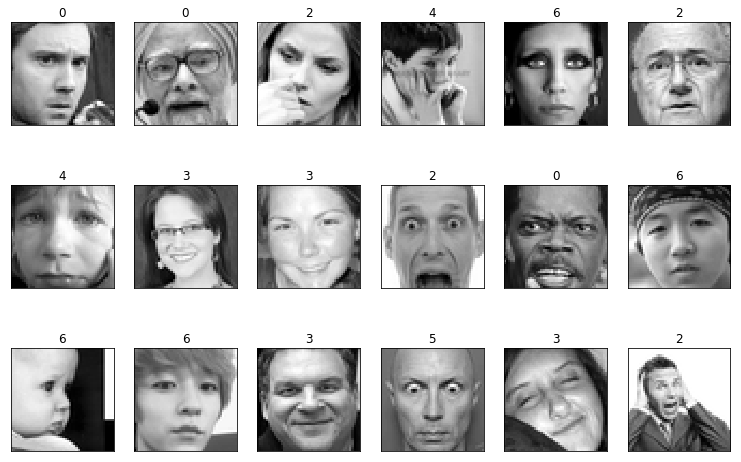

In [4]:
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(df3.pixels, df3.emotion, h, w, 3, 6)

# CNN parts

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model

keras.__version__

Using TensorFlow backend.


'2.2.2'

In [6]:
X_train = df3['pixels'].values
y_train = df3['emotion'].values

X_train = np.concatenate(X_train)
X_train = np.expand_dims(X_train.reshape((len(df3['pixels']),48,48)), axis=3)
X_train.shape


(35887, 48, 48, 1)

In [7]:
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
classes = ['Angry', 'Disgust', 'Fear',
          'Happy', 'Sad','Surprise','Neutral']
img_wh = 48
NUM_CLASSES = len(classes)


In [8]:
from sklearn.model_selection import train_test_split

X = df3['pixels'].values
y = df3['emotion'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=20)
X_train = np.concatenate(X_train)
X_test = np.concatenate(X_test)

X_train = X_train/255.0 - 0.5
X_test = X_test/255.0 - 0.5

X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

print(X_train.shape)
print(X_test.shape)

(28709, 48, 48, 1)
(7178, 48, 48, 1)


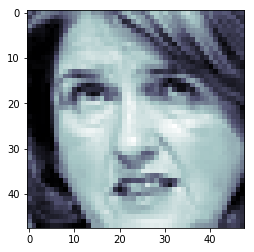

In [9]:
plt.imshow(X_train[1].squeeze(),cmap='bone')
plt.show()

# Modeling

[15 points] Create a convolutional neural network to use on your data using Keras. Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. 

## LeNet

In [10]:
%%time

# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras.layers import average, concatenate
from keras.models import Input, Model
from keras.regularizers import l2
l2_lambda = 0.0001

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=64, # change the number of filters
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)

resnet.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 24, 24, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 24, 24, 32)   18464       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

### Data expansion

Why the data expansion techinique is appropriate for my data?

We are using Face Expression Recognization dataset for this lab. Even for the same emotion of the same person like 'happy', he may perform different facial expressions according to how happy he is, that is, which level of happy he is in at that time. Besides, the face with expressions are more likely to be asymmetric and the head may be in a angle rather that vertical to the ground. Therefore, we use a data generator to generate faces that have slight rotation or symmetric of the original data.

In [11]:
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

# datagen.fit(X_train)

# idx = 0

In [12]:
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
# resnet.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
#                       steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
#                       epochs=50, verbose=1,
#                       validation_data=(X_test,y_test_ohe),
#                       callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
#                      )

# resnet.fit(X_train, y_train_ohe, batch_size=128, 
#                       epochs=50, verbose=1,
#                       validation_data=(X_test,y_test_ohe),
#                       callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
#                      )

# use data expansion
# resnet.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
#                    steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
#                    epochs=30, verbose=1,
#                    validation_data=(X_test,y_test_ohe)
#                   )

## Another CNN architecture

[20 points] Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture). Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).

## Xception

In [13]:
# Xception style architecture
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras.layers import average, concatenate
from keras.models import Input, Model

l2_lambda = 0.000001



input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=64, # change the number of filters
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


x = Activation("relu")(x_split)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES,activation="softmax")(x)

xception_model = Model(inputs=input_holder,outputs=x)

xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 48, 48, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 24, 24, 64)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 24, 24, 32)   18464       max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
max_poolin

In [14]:
# speed up by training by not using augmentation, perhaps there are faster ways??
# xception_model.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
#                 optimizer='adam', # 'adadelta' 'rmsprop'
#                 metrics=['accuracy'])

# xception_model.fit(X_train, y_train_ohe, batch_size=32,
#             epochs=50, verbose=1,
#             validation_data=(X_test,y_test_ohe),
#             callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
#             )

___

## Evaluation of Models

### Define a function of f1 calculation

In [15]:
# Since Keras removed f1_score at version 2.0.0, we use the calculation function from others
# Source: https://github.com/keras-team/keras/issues/5400, by Unnir

from keras import backend as K

def mcor(y_true, y_pred):
     #matthews_correlation
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
 
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
 
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
 
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
 
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
 
    return numerator / (denominator + K.epsilon())

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## Cross validation

Use Stratified K-fold to evaluate the general performance of two models.

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

### Xception performance

In [17]:
from matplotlib import pyplot as plt

n_folds = 10
skf = StratifiedKFold(n_splits=n_folds)

cv_training_f1_score = []
cv_training_loss = []

cv_val_f1_score = []
cv_val_loss = []

xception_model.compile(loss='binary_crossentropy',
              optimizer= "adam",
              metrics=[mcor,recall, f1])

iternum = 1
for train_indices, val_indices in skf.split(X_train, y_train):
    X_tmp_train = X_train[train_indices]
    y_tmp_train = y_train_ohe[train_indices]
    
    X_tmp_val = X_train[val_indices]
    y_tmp_val = y_train_ohe[val_indices]
    
    history = xception_model.fit_generator(datagen.flow(X_tmp_train, y_tmp_train, batch_size=32), 
                   steps_per_epoch=int(len(X_tmp_train)/32), # how many generators to go through per epoch
                   epochs=10, verbose=1,
                   validation_data=(X_tmp_val,y_tmp_val)
                  )
    # save the performance data of different training and validation set
    
    cv_training_f1_score.append(history.history.get('f1'))
    cv_val_f1_score.append(history.history.get('val_f1'))
    
    cv_training_loss.append(history.history.get('loss'))
    cv_val_loss.append(history.history.get('val_loss'))




Epoch 1/10
807/807 [==============================] - 13s 16ms/step - loss: 0.3749 - mcor: 0.0713 - recall: 0.0270 - f1: 0.0482 - val_loss: 0.3464 - val_mcor: 0.2614 - val_recall: 0.1503 - val_f1: 0.2402
Epoch 2/10
807/807 [==============================] - 11s 13ms/step - loss: 0.3502 - mcor: 0.2227 - recall: 0.1047 - f1: 0.1771 - val_loss: 0.3306 - val_mcor: 0.2991 - val_recall: 0.1541 - val_f1: 0.2523
Epoch 3/10
807/807 [==============================] - 10s 13ms/step - loss: 0.3333 - mcor: 0.2890 - recall: 0.1557 - f1: 0.2510 - val_loss: 0.3037 - val_mcor: 0.3652 - val_recall: 0.2275 - val_f1: 0.3446
Epoch 4/10
807/807 [==============================] - 10s 13ms/step - loss: 0.3208 - mcor: 0.3268 - recall: 0.1896 - f1: 0.2960 - val_loss: 0.2963 - val_mcor: 0.3760 - val_recall: 0.2223 - val_f1: 0.3431
Epoch 5/10
807/807 [==============================] - 10s 13ms/step - loss: 0.3115 - mcor: 0.3531 - recall: 0.2144 - f1: 0.3283 - val_loss: 0.2920 - val_mcor: 0.3934 - val_recall: 0.24

807/807 [==============================] - 11s 14ms/step - loss: 0.2701 - mcor: 0.4581 - recall: 0.3367 - f1: 0.4635 - val_loss: 0.2471 - val_mcor: 0.4971 - val_recall: 0.3820 - val_f1: 0.5066
Epoch 2/10
807/807 [==============================] - 11s 13ms/step - loss: 0.2696 - mcor: 0.4597 - recall: 0.3408 - f1: 0.4665 - val_loss: 0.2504 - val_mcor: 0.4844 - val_recall: 0.3496 - val_f1: 0.4810
Epoch 3/10
807/807 [==============================] - 10s 13ms/step - loss: 0.2689 - mcor: 0.4612 - recall: 0.3423 - f1: 0.4683 - val_loss: 0.2539 - val_mcor: 0.4893 - val_recall: 0.3478 - val_f1: 0.4819
Epoch 4/10
807/807 [==============================] - 10s 13ms/step - loss: 0.2706 - mcor: 0.4593 - recall: 0.3396 - f1: 0.4660 - val_loss: 0.2516 - val_mcor: 0.4866 - val_recall: 0.3447 - val_f1: 0.4789
Epoch 5/10
807/807 [==============================] - 11s 13ms/step - loss: 0.2691 - mcor: 0.4596 - recall: 0.3409 - f1: 0.4668 - val_loss: 0.2512 - val_mcor: 0.4910 - val_recall: 0.3687 - val_f1

807/807 [==============================] - 10s 13ms/step - loss: 0.2627 - mcor: 0.4809 - recall: 0.3687 - f1: 0.4935 - val_loss: 0.2389 - val_mcor: 0.5166 - val_recall: 0.3956 - val_f1: 0.5254
Epoch 2/10
807/807 [==============================] - 10s 13ms/step - loss: 0.2630 - mcor: 0.4733 - recall: 0.3642 - f1: 0.4871 - val_loss: 0.2419 - val_mcor: 0.5032 - val_recall: 0.3667 - val_f1: 0.5022
Epoch 3/10
807/807 [==============================] - 10s 13ms/step - loss: 0.2615 - mcor: 0.4820 - recall: 0.3681 - f1: 0.4938 - val_loss: 0.2395 - val_mcor: 0.5158 - val_recall: 0.4019 - val_f1: 0.5276
Epoch 4/10
807/807 [==============================] - 11s 13ms/step - loss: 0.2623 - mcor: 0.4787 - recall: 0.3676 - f1: 0.4916 - val_loss: 0.2381 - val_mcor: 0.5204 - val_recall: 0.4012 - val_f1: 0.5303
Epoch 5/10
807/807 [==============================] - 10s 13ms/step - loss: 0.2628 - mcor: 0.4809 - recall: 0.3689 - f1: 0.4936 - val_loss: 0.2457 - val_mcor: 0.5002 - val_recall: 0.3806 - val_f1

### (Xception) Visualize the training and validation f1_score and loss of each iteration of every fold

Text(0.5,1,'Xception Loss of Each Iteration')

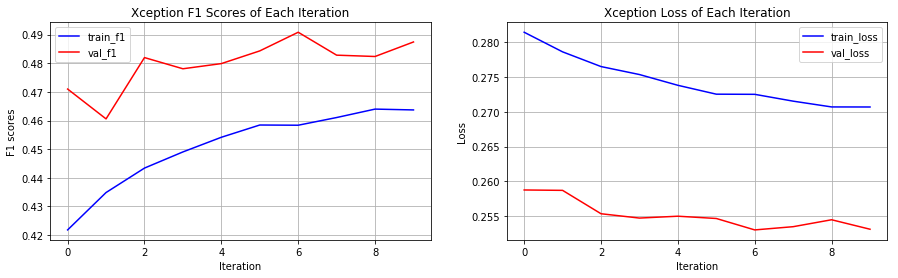

In [18]:
cv_training_f1_fold_average = []
cv_training_loss_fold_average = []
cv_val_f1_fold_average = []
cv_val_loss_fold_average = []
    
for i in range(len(cv_training_f1_score[0])): # 0-30
    tmp_train_f1 = []
    tmp_val_f1 = []
    tmp_train_loss = []
    tmp_val_loss = []
    
    for j in range(len(cv_training_f1_score)): # 0-10
        tmp_train_f1.append(cv_training_f1_score[j][i])
        tmp_val_f1.append(cv_val_f1_score[j][i])
        tmp_train_loss.append(cv_training_loss[j][i])
        tmp_val_loss.append(cv_val_loss[j][i])
        
    cv_training_f1_fold_average.append(np.mean(tmp_train_f1))
    cv_val_f1_fold_average.append(np.mean(tmp_val_f1))
    cv_training_loss_fold_average.append(np.mean(tmp_train_loss))
    cv_val_loss_fold_average.append(np.mean(tmp_val_loss))
    
# plot the performance
iteration = range(0, len(cv_training_f1_score[0]))

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(iteration, cv_training_f1_fold_average, linestyle='-', color='blue', label='train_f1')
plt.plot(iteration, cv_val_f1_fold_average, linestyle='-', color='red', label='val_f1')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('F1 scores')
plt.title('Xception F1 Scores of Each Iteration')


plt.subplot(1,2,2)
plt.plot(iteration, cv_training_loss_fold_average, linestyle='-', color='blue', label='train_loss')
plt.plot(iteration, cv_val_loss_fold_average, linestyle='-', color='red', label='val_loss')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Xception Loss of Each Iteration')

In [60]:
# there are 10 folds, so there are 10 groups of data
# for i in range(0, len(cv_training_f1_score)):
#     iteration = range(1,len(cv_training_f1_score[i])+1)
#     plt.figure(figsize=(20,30))
    
#     plt.subplot(10,2,1)
#     plt.plot(iteration, cv_training_f1_score[i], linestyle='-', color='blue', label='train_f1')
#     plt.plot(iteration, cv_val_f1_score[i], linestyle='-', color='red', label='val_f1')
#     plt.grid()
#     plt.legend()
#     plt.xlabel('Iteration')
#     plt.ylabel('F1 scores')
#     plt.title('F1 scores of Training and Validation sets (No.%.0f fold)' % (i+1))
    
#     plt.subplot(10,2,2)
#     plt.plot(iteration, cv_training_loss[i], linestyle='-', color='blue', label='train_loss')
#     plt.plot(iteration, cv_val_loss[i], linestyle='-', color='red', label='val_loss')
#     plt.grid()
#     plt.legend()
#     plt.xlabel('Iteration')
#     plt.ylabel('Loss')
#     plt.title('Loss of Training and Validation sets (No.%.0f fold)' % (i+1))

### LeNet performance

In [19]:
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds)

cv_training_f1_score = []
cv_training_loss = []

cv_val_f1_score = []
cv_val_loss = []

resnet.compile(loss='binary_crossentropy',
              optimizer= "adam",
              metrics=[mcor,recall, f1])

for train_indices, val_indices in skf.split(X_train, y_train):
    X_tmp_train = X_train[train_indices]
    y_tmp_train = y_train_ohe[train_indices]
    
    X_tmp_val = X_train[val_indices]
    y_tmp_val = y_train_ohe[val_indices]
    
    history = resnet.fit_generator(datagen.flow(X_tmp_train, y_tmp_train, batch_size=128), 
                   steps_per_epoch=int(len(X_tmp_train)/128), # how many generators to go through per epoch
                   epochs=10, verbose=1,
                   validation_data=(X_tmp_val,y_tmp_val)
                  )
    
    cv_training_f1_score.append(history.history.get('f1'))
    cv_val_f1_score.append(history.history.get('val_f1'))
    
    cv_training_loss.append(history.history.get('loss'))
    cv_val_loss.append(history.history.get('val_loss'))


Epoch 1/10
201/201 [==============================] - 10s 50ms/step - loss: 0.4236 - mcor: 0.0222 - recall: 0.0051 - f1: 0.0097 - val_loss: 0.3945 - val_mcor: 0.1208 - val_recall: 0.0285 - val_f1: 0.0545
Epoch 2/10
201/201 [==============================] - 10s 47ms/step - loss: 0.3903 - mcor: 0.1392 - recall: 0.0485 - f1: 0.0882 - val_loss: 0.3609 - val_mcor: 0.2667 - val_recall: 0.1231 - val_f1: 0.2107
Epoch 3/10
201/201 [==============================] - 9s 47ms/step - loss: 0.3697 - mcor: 0.2251 - recall: 0.1026 - f1: 0.1763 - val_loss: 0.3402 - val_mcor: 0.3076 - val_recall: 0.1562 - val_f1: 0.2584
Epoch 4/10
201/201 [==============================] - 9s 47ms/step - loss: 0.3549 - mcor: 0.2793 - recall: 0.1428 - f1: 0.2363 - val_loss: 0.3271 - val_mcor: 0.3521 - val_recall: 0.2094 - val_f1: 0.3259
Epoch 5/10
201/201 [==============================] - 9s 47ms/step - loss: 0.3441 - mcor: 0.3024 - recall: 0.1636 - f1: 0.2653 - val_loss: 0.3192 - val_mcor: 0.3663 - val_recall: 0.2230 

201/201 [==============================] - 10s 47ms/step - loss: 0.2901 - mcor: 0.4387 - recall: 0.3140 - f1: 0.4421 - val_loss: 0.2590 - val_mcor: 0.5037 - val_recall: 0.3740 - val_f1: 0.5088
Epoch 2/10
201/201 [==============================] - 9s 47ms/step - loss: 0.2889 - mcor: 0.4435 - recall: 0.3213 - f1: 0.4494 - val_loss: 0.2619 - val_mcor: 0.5070 - val_recall: 0.3809 - val_f1: 0.5144
Epoch 3/10
201/201 [==============================] - 9s 47ms/step - loss: 0.2879 - mcor: 0.4484 - recall: 0.3242 - f1: 0.4531 - val_loss: 0.2612 - val_mcor: 0.5085 - val_recall: 0.3778 - val_f1: 0.5134
Epoch 4/10
201/201 [==============================] - 10s 48ms/step - loss: 0.2884 - mcor: 0.4468 - recall: 0.3223 - f1: 0.4512 - val_loss: 0.2654 - val_mcor: 0.4922 - val_recall: 0.3565 - val_f1: 0.4929
Epoch 5/10
201/201 [==============================] - 9s 47ms/step - loss: 0.2865 - mcor: 0.4508 - recall: 0.3273 - f1: 0.4562 - val_loss: 0.2620 - val_mcor: 0.4994 - val_recall: 0.3583 - val_f1: 0

201/201 [==============================] - 9s 47ms/step - loss: 0.2774 - mcor: 0.4728 - recall: 0.3565 - f1: 0.4845 - val_loss: 0.2520 - val_mcor: 0.5172 - val_recall: 0.3890 - val_f1: 0.5234
Epoch 2/10
201/201 [==============================] - 9s 47ms/step - loss: 0.2770 - mcor: 0.4752 - recall: 0.3594 - f1: 0.4872 - val_loss: 0.2505 - val_mcor: 0.5191 - val_recall: 0.3942 - val_f1: 0.5277
Epoch 3/10
201/201 [==============================] - 10s 48ms/step - loss: 0.2766 - mcor: 0.4732 - recall: 0.3600 - f1: 0.4868 - val_loss: 0.2544 - val_mcor: 0.5074 - val_recall: 0.3918 - val_f1: 0.5208
Epoch 4/10
201/201 [==============================] - 9s 47ms/step - loss: 0.2761 - mcor: 0.4761 - recall: 0.3616 - f1: 0.4891 - val_loss: 0.2515 - val_mcor: 0.5196 - val_recall: 0.3900 - val_f1: 0.5256
Epoch 5/10
201/201 [==============================] - 9s 47ms/step - loss: 0.2773 - mcor: 0.4700 - recall: 0.3550 - f1: 0.4825 - val_loss: 0.2539 - val_mcor: 0.5207 - val_recall: 0.4134 - val_f1: 0.

### (LeNet) Visualize the training and validation f1_score and loss of each iteration of every fold

Text(0.5,1,'LeNet Loss of Each Iteration')

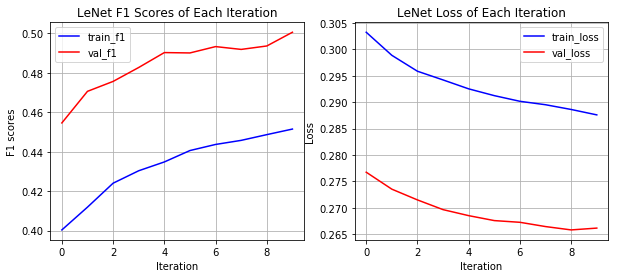

In [20]:
cv_training_f1_fold_average = []
cv_training_loss_fold_average = []
cv_val_f1_fold_average = []
cv_val_loss_fold_average = []
    
for i in range(len(cv_training_f1_score[0])): # 0-30
    tmp_train_f1 = []
    tmp_val_f1 = []
    tmp_train_loss = []
    tmp_val_loss = []
    
    for j in range(len(cv_training_f1_score)): # 0-10
        tmp_train_f1.append(cv_training_f1_score[j][i])
        tmp_val_f1.append(cv_val_f1_score[j][i])
        tmp_train_loss.append(cv_training_loss[j][i])
        tmp_val_loss.append(cv_val_loss[j][i])
        
    cv_training_f1_fold_average.append(np.mean(tmp_train_f1))
    cv_val_f1_fold_average.append(np.mean(tmp_val_f1))
    cv_training_loss_fold_average.append(np.mean(tmp_train_loss))
    cv_val_loss_fold_average.append(np.mean(tmp_val_loss))

# plot the performance
iteration = range(0, len(cv_training_f1_score[0]))

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(iteration, cv_training_f1_fold_average, linestyle='-', color='blue', label='train_f1')
plt.plot(iteration, cv_val_f1_fold_average, linestyle='-', color='red', label='val_f1')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('F1 scores')
plt.title('LeNet F1 Scores of Each Iteration')


plt.subplot(1,2,2)
plt.plot(iteration, cv_training_loss_fold_average, linestyle='-', color='blue', label='train_loss')
plt.plot(iteration, cv_val_loss_fold_average, linestyle='-', color='red', label='val_loss')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('LeNet Loss of Each Iteration')

In [65]:
# there are 10 folds, so there are 10 groups of data
# for i in range(0, len(cv_training_f1_score)):
#     iteration = range(1,len(cv_training_f1_score[i])+1)
#     plt.figure(figsize=(20,30))
#     plt.subplot(10,2,1)
#     plt.plot(iteration, cv_training_f1_score[i], linestyle='-', color='blue', label='train_f1')
#     plt.plot(iteration, cv_val_f1_score[i], linestyle='-', color='red', label='val_f1')
#     plt.grid()
#     plt.legend()
#     plt.xlabel('Iteration')
#     plt.ylabel('F1 scores')
#     plt.title('F1 scores of Training and Validation sets (No.%.0f fold)' % (i+1))
    
#     plt.subplot(10,2,2)
#     plt.plot(iteration, cv_training_loss[i], linestyle='-', color='blue', label='train_loss')
#     plt.plot(iteration, cv_val_loss[i], linestyle='-', color='red', label='val_loss')
#     plt.grid()
#     plt.legend()
#     plt.xlabel('Iteration')
#     plt.ylabel('Loss')
#     plt.title('Loss of Training and Validation sets (No.%.0f fold)' % (i+1))

From the above two groups performance of Xeception architecture and LeNet archtecture, we can see that both of these two models performs well in the testing data. Besides, it looks like the LeNet performs a little bit better and more stable than Xception network.

___

## Xception CNN

In [21]:
# speed up by training by not using augmentation, perhaps there are faster ways??
xception_model.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=[mcor,recall, f1])

x_history = xception_model.fit(X_train, y_train_ohe, batch_size=32,
            epochs=50, verbose=1,
            validation_data=(X_test,y_test_ohe),
            callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
            )

Train on 28709 samples, validate on 7178 samples
Epoch 1/50
28709/28709 [==============================] - 10s 342us/step - loss: 1.0896 - mcor: 0.5082 - recall: 0.4082 - f1: 0.5283 - val_loss: 1.0736 - val_mcor: 0.5090 - val_recall: 0.3906 - val_f1: 0.5198
Epoch 2/50
28709/28709 [==============================] - 9s 306us/step - loss: 1.0544 - mcor: 0.5241 - recall: 0.4232 - f1: 0.5442 - val_loss: 1.0591 - val_mcor: 0.5151 - val_recall: 0.3950 - val_f1: 0.5252
Epoch 3/50
28709/28709 [==============================] - 8s 291us/step - loss: 1.0338 - mcor: 0.5360 - recall: 0.4363 - f1: 0.5569 - val_loss: 1.0579 - val_mcor: 0.5178 - val_recall: 0.4029 - val_f1: 0.5308
Epoch 4/50
28709/28709 [==============================] - 9s 303us/step - loss: 1.0154 - mcor: 0.5395 - recall: 0.4436 - f1: 0.5619 - val_loss: 1.0530 - val_mcor: 0.5254 - val_recall: 0.4092 - val_f1: 0.5381
Epoch 5/50
28709/28709 [==============================] - 8s 291us/step - loss: 0.9936 - mcor: 0.5449 - recall: 0.4519

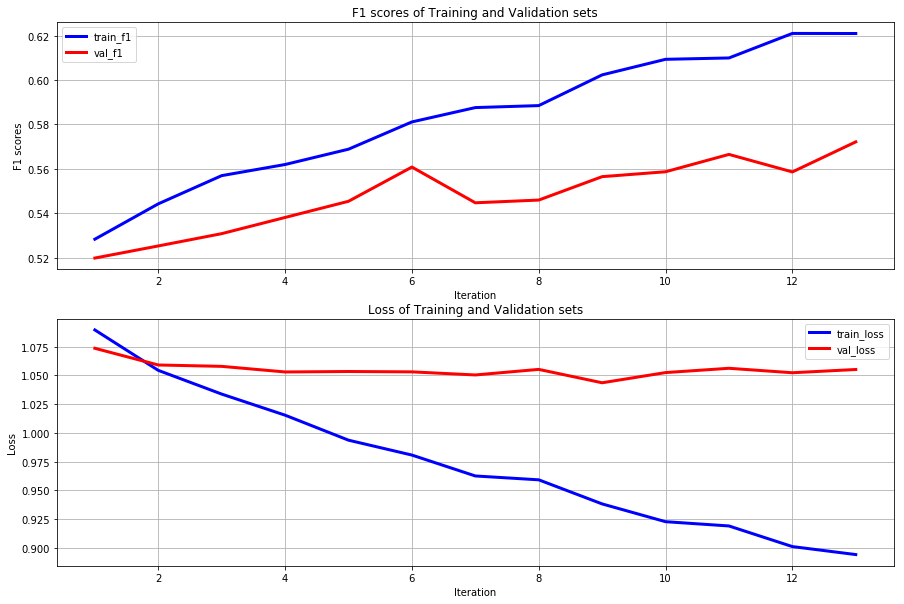

In [22]:
## visualize the performance of training and validation set of each iteration
from matplotlib import pyplot as plt

iteration = range(1,len(x_history.history.get('f1'))+1)

train_f1 = x_history.history.get('f1')
train_loss = x_history.history.get('loss')

val_f1 = x_history.history.get('val_f1')
val_loss = x_history.history.get('val_loss')

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(iteration, train_f1, linestyle='-', lw=3, color='blue', label='train_f1')
plt.plot(iteration, val_f1, linestyle='-', lw=3, color='red', label='val_f1')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('F1 scores')
plt.title('F1 scores of Training and Validation sets')

plt.subplot(2,1,2)
plt.plot(iteration, train_loss, lw=3, color='blue', label='train_loss')
plt.plot(iteration, val_loss, lw=3, color='red', label='val_loss')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss of Training and Validation sets')
plt.show()

___

### Visualize the final results of the CNNs and interpret the performance. Use proper statistics as appropriate, especially for comparing models. 

# Proper Statistics ????? How ???

#### Xception

In [23]:
# speed up by training by not using augmentation, perhaps there are faster ways??
xception_model.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=[mcor,recall, f1])

x_history = xception_model.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Epoch 1/50
224/224 [==============================] - 12s 52ms/step - loss: 1.1698 - mcor: 0.4787 - recall: 0.3729 - f1: 0.4967 - val_loss: 1.0613 - val_mcor: 0.5200 - val_recall: 0.3983 - val_f1: 0.5296
Epoch 2/50
224/224 [==============================] - 11s 48ms/step - loss: 1.1449 - mcor: 0.4814 - recall: 0.3677 - f1: 0.4951 - val_loss: 1.0786 - val_mcor: 0.5114 - val_recall: 0.3965 - val_f1: 0.5261
Epoch 3/50
224/224 [==============================] - 11s 48ms/step - loss: 1.1415 - mcor: 0.4840 - recall: 0.3730 - f1: 0.4995 - val_loss: 1.0715 - val_mcor: 0.5150 - val_recall: 0.3945 - val_f1: 0.5268
Epoch 4/50
224/224 [==============================] - 11s 47ms/step - loss: 1.1362 - mcor: 0.4867 - recall: 0.3741 - f1: 0.5015 - val_loss: 1.0742 - val_mcor: 0.5135 - val_recall: 0.3897 - val_f1: 0.5234
Epoch 5/50
224/224 [==============================] - 11s 47ms/step - loss: 1.1300 - mcor: 0.4916 - recall: 0.3777 - f1: 0.5059 - val_loss: 1.0760 - val_mcor: 0.5139 - val_recall: 0.39

#### LeNet

In [24]:
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=[mcor,recall, f1])

# the flow method yields batches of images indefinitely, with the given transofmrations
res_history = resnet.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Epoch 1/50
224/224 [==============================] - 11s 51ms/step - loss: 1.1615 - mcor: 0.4798 - recall: 0.3660 - f1: 0.4935 - val_loss: 1.0759 - val_mcor: 0.5245 - val_recall: 0.4159 - val_f1: 0.5428
Epoch 2/50
224/224 [==============================] - 11s 48ms/step - loss: 1.1537 - mcor: 0.4835 - recall: 0.3683 - f1: 0.4965 - val_loss: 1.0828 - val_mcor: 0.5206 - val_recall: 0.4157 - val_f1: 0.5407
Epoch 3/50
224/224 [==============================] - 11s 48ms/step - loss: 1.1531 - mcor: 0.4815 - recall: 0.3675 - f1: 0.4950 - val_loss: 1.0848 - val_mcor: 0.5188 - val_recall: 0.3906 - val_f1: 0.5265
Epoch 4/50
224/224 [==============================] - 11s 47ms/step - loss: 1.1519 - mcor: 0.4832 - recall: 0.3698 - f1: 0.4973 - val_loss: 1.0806 - val_mcor: 0.5238 - val_recall: 0.4096 - val_f1: 0.5394
Epoch 5/50
224/224 [==============================] - 11s 47ms/step - loss: 1.1468 - mcor: 0.4841 - recall: 0.3693 - f1: 0.4973 - val_loss: 1.1015 - val_mcor: 0.5159 - val_recall: 0.40

7178/7178 [==============================] - 1s 105us/step
Performance of Xception
loss : 1.076003002054215
mcor : 0.5126421569150349
recall : 0.39203120649741136
f1 : 0.5223921724234692


7178/7178 [==============================] - 1s 114us/step
Performance of LeNet
loss : 1.1014588972956865
mcor : 0.5150821498258096
recall : 0.401922541131014
f1 : 0.5290977802074663


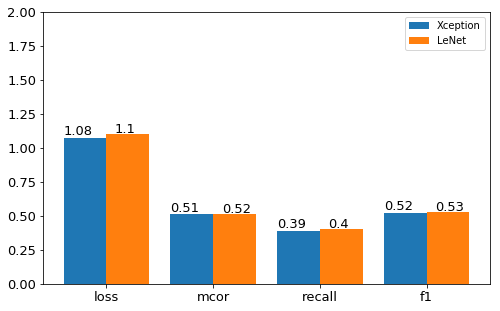

In [27]:
xcep_performance = xception_model.evaluate(X_test, y_test_ohe)

print('Performance of Xception')
for i in range(len(xception_model.metrics_names)):
    print(xception_model.metrics_names[i], ': '+str(xcep_performance[i]))

print('\n')

res_performance = resnet.evaluate(X_test, y_test_ohe)
print('Performance of LeNet')
for i in range(len(resnet.metrics_names)):
    print(resnet.metrics_names[i], ': '+str(res_performance[i]))

# Visualize the final results of the CNNs and interpret the performance. 
# Use proper statistics as appropriate, especially for comparing models.

mn = xception_model.metrics_names
width = 0.4
index = range(len(xcep_performance))
x1 = [i-0.2 for i in index]
x2 = [i+0.2 for i in index]
# change the figure size
plt.figure(figsize=(8,5))

# plot the bars
plt.bar(x1, xcep_performance, width=width, label='Xception')
plt.bar(x2, res_performance, width=width, label='LeNet')

# change the integer xlabels into text
plt.xticks(index, mn, fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,2.0)

# add data label on each of the bar
for a,b in zip(x1, xcep_performance):
    plt.text(a-0.2, b+0.02, np.round(b,2), fontsize=13)
for a,b in zip(x2, res_performance):
    plt.text(a-0.12, b+0.01, np.round(b,2), fontsize=13)

plt.legend()

[10 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

## Standard sklearn MLP

In [28]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

X_clf = df3['pixels'].values
y_clf = df3['emotion'].values

X_clf = np.concatenate(X_clf)
X_clf = X_clf.reshape((len(df3['pixels']),2304))

X_clf = X_clf/255.0 - 0.5

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, shuffle=True)

# these values have been hand tuned
clf = MLPClassifier(hidden_layer_sizes=(50,), 
                    activation='logistic', 
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size='auto', # min of 200, num_samples
                    learning_rate='constant', 
                    learning_rate_init=0.1, # only SGD
                    power_t=0.5,    # only SGD
                    max_iter=200, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train_clf,y_train_clf)
yhat = clf.predict(X_test_clf)
print('F1 scores:',f1_score(yhat,y_test_clf,average='macro'))
print('Validation Acc:',accuracy_score(yhat,y_test_clf))


CPU times: user 59min 57s, sys: 4min 26s, total: 1h 4min 24s
Wall time: 1min 54s
F1 scores: 0.3475129783910012
Validation Acc: 0.3774031763722485


In [33]:
for i, (train, test) in enumerate(skf.split(X_train_clf, y_train_clf)):
    a = np.unique(y_train_clf[train])
    print(a)

[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]


ROC
Epoch 1/1
25834/25834 [==============================] - 7s 257us/step - loss: 0.7865 - mcor: 0.6440 - recall: 0.5843 - f1: 0.6758
Epoch 1/1
25837/25837 [==============================] - 6s 250us/step - loss: 0.7778 - mcor: 0.6451 - recall: 0.5882 - f1: 0.6777
Epoch 1/1
25837/25837 [==============================] - 6s 251us/step - loss: 0.7784 - mcor: 0.6471 - recall: 0.5912 - f1: 0.6797
Epoch 1/1
25837/25837 [==============================] - 7s 252us/step - loss: 0.7685 - mcor: 0.6518 - recall: 0.5962 - f1: 0.6843
Epoch 1/1
25837/25837 [==============================] - 6s 250us/step - loss: 0.7608 - mcor: 0.6571 - recall: 0.6036 - f1: 0.6895
Epoch 1/1
25839/25839 [==============================] - 6s 250us/step - loss: 0.7646 - mcor: 0.6545 - recall: 0.5986 - f1: 0.6866
Epoch 1/1
25840/25840 [==============================] - 7s 253us/step - loss: 0.7450 - mcor: 0.6637 - recall: 0.6110 - f1: 0.6959
Epoch 1/1
25840/25840 [==============================] - 7s 252us/step - loss: 

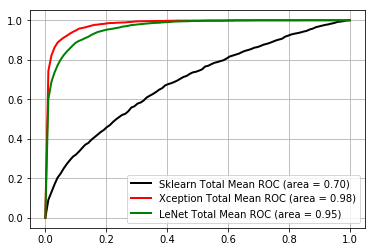

In [40]:
%%time
# Great! Its seems we are also maxing out the F1 score, lets go with C==1e-3
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.model_selection import StratifiedKFold
print("ROC")
# K = 4

# if sklearn_version < '0.18':
#     from sklearn.cross_validation import StratifiedKFold
#     kfold = StratifiedKFold(y=y_train, 
#                             n_folds=K,
#                             random_state=1)
# else:
#     from sklearn.model_selection import StratifiedKFold
#     kfold = StratifiedKFold(n_splits=K,
#                             random_state=1).split(X_train, y_train)


########################### Sklearn ###############
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(skf.split(X_train_clf, y_train_clf)):
    probas = clf.fit(X_train_clf[train],
                         y_train_clf[train]).predict_proba(X_train_clf[test])
    
    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_train_clf[train])
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_train_clf[test],
                                         probas[:, j],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)
        
    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    
    # plot the ROC of each fold
#     plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Sklearn Mean Class ROC fold %d (area = %0.2f)'
#                    % (i+1, roc_auc))
    
mean_tpr /= n_folds
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,color='black',
         label='Sklearn Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
# plt.legend(loc='best')
# plt.grid()


########################### Xception ###############
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(skf.split(X_train, y_train)):
    hX_train= xception_model.fit(X_train[train],y_train_ohe[train])
    probas = xception_model.predict(X_train[test])

    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_train[train])
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_train[test],
                                         probas[:, j],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)
        
    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    
    # plot the ROC of each fold
#     plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Sklearn Mean Class ROC fold %d (area = %0.2f)'
#                    % (i+1, roc_auc))
    
mean_tpr /= n_folds
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,color='red',
         label='Xception Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
# plt.legend(loc='best')
# plt.grid()

########################### LeNet ###############
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(skf.split(X_train, y_train)):
    history = resnet.fit(X_train[train],y_train_ohe[train])
    probas = resnet.predict(X_train[test])

    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_train[train])
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_train[test],
                                         probas[:, j],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)
        
    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    
    # plot the ROC of each fold
#     plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Sklearn Mean Class ROC fold %d (area = %0.2f)'
#                    % (i+1, roc_auc))
    
mean_tpr /= n_folds
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,color='green', 
         label='LeNet Total Mean ROC (area = %0.2f)'
                   % (mean_auc))

plt.legend(loc='best')
plt.grid()

As what the ROC graph above shows, Xception/LeNet architecture has a larger area under the curve than sklearn, which also means it performs better and easier to disguish different label classes.

# Exceptional work

## Transfer learn

Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training from scratch in terms of classification performance. 

In [41]:
X = df3['pixels'].values
y = df3['emotion'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=20)
X_train = np.concatenate(X_train)
X_test = np.concatenate(X_test)

X_train = X_train/255.0 - 0.5
X_test = X_test/255.0 - 0.5

print(X_train.shape)
print(X_test.shape)

X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

print(X_train.shape)
print(X_test.shape)

(66145536,)
(16538112,)
(28709, 48, 48, 1)
(7178, 48, 48, 1)


In [42]:
# from skimage.transform import resize
# resize the data

from scipy.misc import imresize
from skimage.transform import resize
import numpy as np
import skimage

# convert the gray scale image to rgb (3 channels)

x_train_up = [skimage.color.gray2rgb(np.resize(x, (48,48))) 
              for x in X_train]
# x_train_up = [resize(x, output_shape=(48,48,3)) for x in X_train]
x_train_up = np.stack(x_train_up, axis=0)
print(x_train_up.shape)

x_test_up = [skimage.color.gray2rgb(np.resize(x, (48,48))) 
             for x in X_test]
x_test_up = np.stack(x_test_up, axis=0)
print(x_test_up.shape)


(28709, 48, 48, 3)
(7178, 48, 48, 3)


In [43]:
## for test
# x1 = x_train_up[0].copy()

# x1 = np.expand_dims(x1, axis=0)
# x1 = preprocess_input(x1)
# print(x1.shape)
# plt.imshow(x1[0])

In [44]:
# connect new layers to the output
from keras.applications.xception import xception
from keras.applications.xception import preprocess_input, decode_predictions

# load only convolutional layers of resnet:
xception_no_top = xception.Xception(weights='imagenet', include_top=False)
# xception_no_top.summary()

## performance on scratch
x = x_train_up[0].copy()
# x = resize(x, output_shape=(48,48,3))
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
%time preds = xception_no_top.predict(x)
preds.shape

CPU times: user 792 ms, sys: 21.5 ms, total: 813 ms
Wall time: 811 ms


(1, 2, 2, 2048)

In [45]:
# pre-process the input data
x_train_up = preprocess_input(x_train_up)
x_test_up = preprocess_input(x_test_up)

In [46]:
%%time

# train on half the data, to save a few hours
x_train_xception = xception_no_top.predict(x_train_up)
x_test_xception = xception_no_top.predict(x_test_up)
print(x_train_xception.shape)

(28709, 2, 2, 2048)
CPU times: user 21.1 s, sys: 2.77 s, total: 23.9 s
Wall time: 15.6 s


In [47]:
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add, Flatten, Dense
from keras.layers import average, concatenate
from keras.models import Input, Model


# let's add a fully-connected layer
input_x = Input(shape=x_train_xception[0].shape)
x = Flatten()(input_x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=input_x, outputs=predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               1638600   
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 1407      
Total params: 1,640,007
Trainable params: 1,640,007
Non-trainable params: 0
_________________________________________________________________


In [48]:
# fit the data with pre-trained model

y_train_ohe_xception = y_train_ohe[:x_train_xception.shape[0]]

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=[mcor,recall, f1])

tl_history = model.fit(x_train_xception,y_train_ohe_xception,
                epochs=20,
                batch_size=64,
                verbose=1,
                validation_data=(x_test_xception, y_test_ohe[:x_test_xception.shape[0]]),
                callbacks = [EarlyStopping(monitor='val_loss', patience=4)])

Train on 28709 samples, validate on 7178 samples
Epoch 1/20
28709/28709 [==============================] - 3s 116us/step - loss: 1.7925 - mcor: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 1.7733 - val_mcor: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/20
28709/28709 [==============================] - 2s 76us/step - loss: 1.7563 - mcor: 8.4110e-04 - recall: 1.7416e-04 - f1: 3.3613e-04 - val_loss: 1.8063 - val_mcor: 0.0769 - val_recall: 0.0287 - val_f1: 0.0532
Epoch 3/20
28709/28709 [==============================] - 2s 75us/step - loss: 1.7379 - mcor: 0.0087 - recall: 0.0019 - f1: 0.0037 - val_loss: 1.7416 - val_mcor: 0.0019 - val_recall: 4.1794e-04 - val_f1: 8.2303e-04
Epoch 4/20
28709/28709 [==============================] - 2s 75us/step - loss: 1.7228 - mcor: 0.0291 - recall: 0.0062 - f1: 0.0118 - val_loss: 1.7142 - val_mcor: 0.0159 - val_recall: 0.0025 - val_f1: 0.0049
Epoch 5/20
28709/28709 [==============================] - 2s 77us/step - loss:

In [49]:
# get the performance of 3 models by evaluating with test data
tl_performance = model.evaluate(x_test_xception, y_test_ohe[:x_test_xception.shape[0]])
xcep_performance = xception_model.evaluate(X_test, y_test_ohe)
lenet_performance = resnet.evaluate(X_test, y_test_ohe)

7178/7178 [==============================] - 1s 89us/step


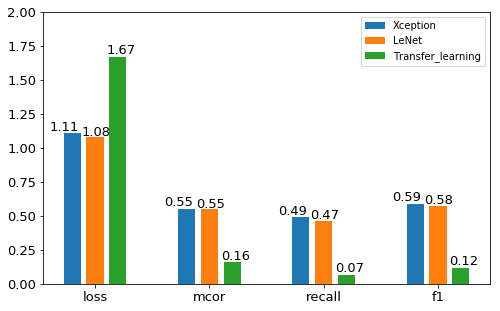

In [50]:
# visualize and compare the performance 

mn = model.metrics_names
width = 0.15
index = range(len(xcep_performance))
x1 = [i-0.2 for i in index]
x2 = [i for i in index]
x3 = [i+0.2 for i in index]
# change the figure size
plt.figure(figsize=(8,5))

# plot the bars
plt.bar(x1, xcep_performance, width=width, label='Xception')
plt.bar(x2, lenet_performance, width=width, label='LeNet')
plt.bar(x3, tl_performance, width=width, label='Transfer_learning')

# change the integer xlabels into text
plt.xticks(index, mn, fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,2.0)

# add data label on each of the bar
for a,b in zip(x1, xcep_performance):
    plt.text(a-0.2, b+0.02, np.round(b,2), fontsize=13)
for a,b in zip(x2, lenet_performance):
    plt.text(a-0.12, b+0.01, np.round(b,2), fontsize=13)
for a,b in zip(x3, tl_performance):
    plt.text(a-0.1, b+0.02, np.round(b,2), fontsize=13)
plt.legend()

As we can see above, the pre-trained Xceoption model has a terrible performance on our dataset, which has only 0.1 f1_socres and a very high 1.6 loss. We think one of the reason of the bad performance of this pre-trained model is that our dataset is originally gray scale images which have only one channel. However, the 'ImageNet' that is used to pre-train the model has 3 channels in each image of it. The image size of our dataset 48x48 pixels in 1 channel (48,48,1), but there was a error when we tried to fit them into the model which is 'the input_6 layer requires to be (None, None, 3)'. In order to meet the requirement, we 'had to' convert the gray scale image into RGB style. As a result, the performance drops dramatically.